In [ ]:
# 改善版：NTT株価データの特徴量エンジニアリング（技術力強化版）
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import japanize_matplotlib  ← 使用しない
from sklearn.preprocessing import MinMaxScaler
import talib
import warnings
warnings.filterwarnings('ignore')

# グラフ設定
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# データの読み込み
df = pd.read_csv(r"C:\Users\Take\python\ntt-stock-prediction_test\data\data.csv")
df['Date'] = pd.to_datetime(df['Date'])

def extend_feature_engineering(df_feat):
    """
    既存の `generate_features_with_talib()` に含まれていない、以下の特徴量を追加します：
    - 出来高の変化率・平均比率
    - ゴールデンクロス・MACD関連
    - イベントフラグ（決算・配当日）
    - 加速度・変化の変化系
    """
    close = df_feat['Close'].astype(np.float64).values
    volume = df_feat['Volume'].astype(np.float64).values

    # 出来高の変化率と比率
    df_feat['Volume_Change'] = df_feat['Volume'].pct_change()
    df_feat['Volume_Ratio_5'] = df_feat['Volume'] / df_feat['Volume'].rolling(5).mean()

    # ゴールデンクロス・デッドクロス（SMA 50 > SMA 200）
    df_feat['SMA_50'] = talib.SMA(close, timeperiod=50)
    df_feat['SMA_200'] = talib.SMA(close, timeperiod=200)
    df_feat['SMA_Cross_50_200'] = (df_feat['SMA_50'] > df_feat['SMA_200']).astype(int)

    # MACD - SIGNAL 差分
    macd, macd_signal, _ = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    df_feat['MACD_Diff'] = macd - macd_signal

    # 加速度的特徴量（差分の差分）
    df_feat['Return_Lag_5'] = df_feat['Close'].pct_change(5).shift(5)
    df_feat['Return_Lag_10'] = df_feat['Close'].pct_change(10).shift(10)
    df_feat['Acceleration_5_10'] = df_feat['Return_Lag_5'] - df_feat['Return_Lag_10']

    # イベントフラグ：決算/配当（仮に毎年3月末、6月末、9月末、12月末とする）
    df_feat['Is_Earnings_Season'] = df_feat['Date'].dt.month.isin([3, 6, 9, 12]).astype(int)
    df_feat['Is_Month_End'] = df_feat['Date'].dt.is_month_end.astype(int)

    return df_feat

def generate_features_with_talib(df):
    """TALibを最大限活用した特徴量生成"""
    df_feat = df.copy()
    
    high = df_feat['High'].astype(np.float64).values
    low = df_feat['Low'].astype(np.float64).values
    close = df_feat['Close'].astype(np.float64).values
    open_price = df_feat['Open'].astype(np.float64).values
    volume = df_feat['Volume'].astype(np.float64).values

    # 時間関連
    df_feat['Year'] = df_feat['Date'].dt.year
    df_feat['Month'] = df_feat['Date'].dt.month
    df_feat['Day'] = df_feat['Date'].dt.day
    df_feat['Weekday'] = df_feat['Date'].dt.dayofweek
    df_feat['Quarter'] = df_feat['Date'].dt.quarter
    df_feat['Week_of_year'] = df_feat['Date'].dt.isocalendar().week
    df_feat['Is_month_start'] = df_feat['Date'].dt.is_month_start.astype(int)
    df_feat['Is_month_end'] = df_feat['Date'].dt.is_month_end.astype(int)

    # 曜日 → sin/cos変換
    df_feat['Weekday_sin'] = np.sin(2 * np.pi * df_feat['Weekday'] / 7)
    df_feat['Weekday_cos'] = np.cos(2 * np.pi * df_feat['Weekday'] / 7)

    # 月 → sin/cos変換
    df_feat['Month_sin'] = np.sin(2 * np.pi * df_feat['Month'] / 12)
    df_feat['Month_cos'] = np.cos(2 * np.pi * df_feat['Month'] / 12)

    # 四半期 → sin/cos変換
    df_feat['Quarter_sin'] = np.sin(2 * np.pi * df_feat['Quarter'] / 4)
    df_feat['Quarter_cos'] = np.cos(2 * np.pi * df_feat['Quarter'] / 4)


    # 基本価格系
    df_feat['Daily_Return'] = df_feat['Close'].pct_change()
    df_feat['Log_Return'] = np.log(df_feat['Close'] / df_feat['Close'].shift(1))
    df_feat['Range'] = high - low
    df_feat['Range_Ratio'] = df_feat['Range'] / close
    df_feat['Body'] = abs(close - open_price)
    df_feat['Body_Ratio'] = df_feat['Body'] / df_feat['Range']
    df_feat['Upper_Shadow'] = high - np.maximum(open_price, close)
    df_feat['Lower_Shadow'] = np.minimum(open_price, close) - low
    df_feat['Gap'] = (open_price - np.roll(close, 1)) / np.roll(close, 1)

    # 移動平均・EMA
    for period in [5, 10, 20, 50, 100, 200]:
        df_feat[f'SMA_{period}'] = talib.SMA(close, timeperiod=period)
        df_feat[f'SMA_Ratio_{period}'] = close / df_feat[f'SMA_{period}']
        if period <= 50:
            df_feat[f'EMA_{period}'] = talib.EMA(close, timeperiod=period)
            df_feat[f'EMA_Ratio_{period}'] = close / df_feat[f'EMA_{period}']

    for period in [9, 14, 21]:
        df_feat[f'RSI_{period}'] = talib.RSI(close, timeperiod=period)

    macd, macd_signal, macd_hist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    df_feat['MACD'] = macd
    df_feat['MACD_Signal'] = macd_signal
    df_feat['MACD_Hist'] = macd_hist

    slowk, slowd = talib.STOCH(high, low, close, 14, 3, 3)
    df_feat['STOCH_K'] = slowk
    df_feat['STOCH_D'] = slowd

    df_feat['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)
    df_feat['CCI'] = talib.CCI(high, low, close, timeperiod=14)

    for period in [5, 10, 20]:
        df_feat[f'ROC_{period}'] = talib.ROC(close, timeperiod=period)
        df_feat[f'MOM_{period}'] = talib.MOM(close, timeperiod=period)

    df_feat['ATR_14'] = talib.ATR(high, low, close, timeperiod=14)
    df_feat['ATR_Ratio'] = df_feat['ATR_14'] / close
    df_feat['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df_feat['TRANGE'] = talib.TRANGE(high, low, close)

    bb_upper, bb_middle, bb_lower = talib.BBANDS(close, 20, 2, 2)
    df_feat['BB_Upper'] = bb_upper
    df_feat['BB_Middle'] = bb_middle
    df_feat['BB_Lower'] = bb_lower
    df_feat['BB_Width'] = (bb_upper - bb_lower) / bb_middle
    df_feat['BB_Position'] = (close - bb_lower) / (bb_upper - bb_lower)

    df_feat['AD'] = talib.AD(high, low, close, volume)
    df_feat['ADOSC'] = talib.ADOSC(high, low, close, volume, 3, 10)
    df_feat['OBV'] = talib.OBV(close, volume)
    df_feat['OBV_Change'] = df_feat['OBV'].pct_change()

    df_feat['CDLDOJI'] = talib.CDLDOJI(open_price, high, low, close)
    df_feat['CDLHAMMER'] = talib.CDLHAMMER(open_price, high, low, close)
    df_feat['CDLENGULFING'] = talib.CDLENGULFING(open_price, high, low, close)

    for period in [5, 10, 20]:
        df_feat[f'STDDEV_{period}'] = talib.STDDEV(close, timeperiod=period)

    df_feat['VAR_20'] = talib.VAR(close, timeperiod=20)
    df_feat['LINEARREG_14'] = talib.LINEARREG(close, timeperiod=14)
    df_feat['LINEARREG_SLOPE_14'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df_feat['TSF_14'] = talib.TSF(close, timeperiod=14)

    df_feat['TYPPRICE'] = talib.TYPPRICE(high, low, close)
    df_feat['WCLPRICE'] = talib.WCLPRICE(high, low, close)
    df_feat['MEDPRICE'] = talib.MEDPRICE(high, low)

    aroon_down, aroon_up = talib.AROON(high, low, timeperiod=14)
    df_feat['AROON_DOWN'] = aroon_down
    df_feat['AROON_UP'] = aroon_up
    df_feat['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)

    df_feat['DX'] = talib.DX(high, low, close, timeperiod=14)
    df_feat['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df_feat['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df_feat['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df_feat['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)

    for lag in [1, 2, 3, 5, 10]:
        df_feat[f'Close_Lag_{lag}'] = df_feat['Close'].shift(lag)
        df_feat[f'Return_Lag_{lag}'] = df_feat['Daily_Return'].shift(lag)
        df_feat[f'Volume_Lag_{lag}'] = df_feat['Volume'].shift(lag)

    for forward in [1, 3, 5, 10]:
        df_feat[f'Forward_Return_{forward}d'] = df_feat['Close'].pct_change(periods=forward).shift(-forward)
        df_feat[f'Forward_Direction_{forward}d'] = np.where(df_feat[f'Forward_Return_{forward}d'] > 0, 1, 0)

    df_feat = df_feat.dropna()
    df_feat = extend_feature_engineering(df_feat)
    return df_feat.dropna()

# 特徴量重要度（時系列対応）
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

def evaluate_feature_importance_timeseries(df, target_col='Close', n_splits=5):
    y = df[target_col].values
    X = df.drop(['Date', 'Forward_Return_1d', 'Forward_Return_3d', 'Forward_Return_5d', 
                 'Forward_Return_10d', 'Forward_Direction_1d', 'Forward_Direction_3d', 
                 'Forward_Direction_5d', 'Forward_Direction_10d',target_col], axis=1)
    
    X = pd.get_dummies(X, columns=['Weekday', 'Month', 'Quarter'], drop_first=True)
    X = X.select_dtypes(include=[np.number])
    X_values = X.values
    feature_names = X.columns
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    importances = []

    for train_index, test_index in tscv.split(X_values):
        X_train, X_test = X_values[train_index], X_values[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = RandomForestRegressor(n_estimators=20, random_state=42)  # 処理時間短縮
        model.fit(X_train, y_train)
        importances.append(model.feature_importances_)

    mean_importance = np.mean(importances, axis=0)
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': mean_importance
    }).sort_values('Importance', ascending=False)

    print("上位の特徴量（Top 30）:")
    print(feature_importance.head(30))

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(30))
    plt.title('Top 30 Important Features (TALib Enhanced)')
    plt.tight_layout()
    plt.show()

    return feature_importance

# メイン関数
def main():
    df_features = generate_features_with_talib(df)
    print(f"生成された特徴量の数: {df_features.shape[1] - 1}")
    print(f"データ行数: {df_features.shape[0]}")
    
    talib_features = [col for col in df_features.columns if any(x in col for x in 
                     ['RSI', 'MACD', 'STOCH', 'WILLR', 'CCI', 'ROC', 'MOM', 'ATR', 'NATR', 
                      'BB_', 'AD', 'OBV', 'CDL', 'STDDEV', 'VAR', 'LINEARREG', 'TSF',
                      'TYPPRICE', 'WCLPRICE', 'MEDPRICE', 'AROON', 'DX', 'ADX', 'PLUS_DI', 'MINUS_DI'])]
    
    print(f"\nTALibで生成された特徴量数: {len(talib_features)}")
    for feature in sorted(talib_features):
        print(f"  - {feature}")
    
    feature_importance = evaluate_feature_importance_timeseries(df_features)
    
    df_features.to_csv(r"C:\Users\Take\python\ntt-stock-prediction_test\data\features_talib.csv", index=False)
    print("\n特徴量エンジニアリングが完了し、結果を保存しました。")
    print("ファイル: features_talib.csv")
    
    return df_features,feature_importance

if __name__ == "__main__":
    df_features,feature_importance = main()

# 重要なやつ）
top_30 = feature_importance.head(35)

# CSV保存
top_30.to_csv(r"C:\Users\Take\python\ntt-stock-prediction_test\data\top_30_feature_importance.csv", index=False)

print("上位30特徴量を保存しました → top_30_feature_importance.csv")

from scipy.stats import ks_2samp

def run_ks_test(train_df, test_df):
    result = []
    common_cols = set(train_df.columns).intersection(set(test_df.columns))
    
    for col in common_cols:
        if pd.api.types.is_numeric_dtype(train_df[col]):
            stat, p = ks_2samp(train_df[col].dropna(), test_df[col].dropna())
            result.append({
                'Feature': col,
                'ks_stat': round(stat, 4),
                'p_value': round(p, 4),
                'drift_detected': p < 0.05
            })

    return pd.DataFrame(result).sort_values('ks_stat', ascending=False)

# 🔻 追加処理
# データ分割：未来30日 vs 過去学習用（今回は最後の30行をfutureと仮定）
df_future = df_features.tail(30)
df_train = df_features.iloc[:-30]

# KS検定
ks_result = run_ks_test(df_train, df_future)

# 重要度とマージ
combined_result = pd.merge(feature_importance, ks_result, on='Feature', how='inner')

# 並び替えと表示
combined_result = combined_result.sort_values(['drift_detected', 'Importance'], ascending=[False, False])
print("\n★ 重要度 × ドリフト検出 結果（上位）:")
print(combined_result.head(30))

# 必要に応じてCSV保存
combined_result.to_csv(r"C:\Users\Take\python\ntt-stock-prediction_test\data\feature_drift_analysis.csv", index=False)
print("\n分析結果を保存しました → feature_drift_analysis.csv")


生成された特徴量の数: 130
データ行数: 8792

TALibで生成された特徴量数: 50
  - AD
  - ADOSC
  - ADX
  - ADXR
  - AROONOSC
  - AROON_DOWN
  - AROON_UP
  - ATR_14
  - ATR_Ratio
  - BB_Lower
  - BB_Middle
  - BB_Position
  - BB_Upper
  - BB_Width
  - CCI
  - CDLDOJI
  - CDLENGULFING
  - CDLHAMMER
  - DX
  - LINEARREG_14
  - LINEARREG_SLOPE_14
  - MACD
  - MACD_Diff
  - MACD_Hist
  - MACD_Signal
  - MEDPRICE
  - MINUS_DI
  - MOM_10
  - MOM_20
  - MOM_5
  - NATR
  - OBV
  - OBV_Change
  - PLUS_DI
  - ROC_10
  - ROC_20
  - ROC_5
  - RSI_14
  - RSI_21
  - RSI_9
  - STDDEV_10
  - STDDEV_20
  - STDDEV_5
  - STOCH_D
  - STOCH_K
  - TSF_14
  - TYPPRICE
  - VAR_20
  - WCLPRICE
  - WILLR


データ読み込み完了: (9201, 11)
生成された特徴量の数: 125
データ行数: 8991

TALibで生成された特徴量数: 51

高相関特徴量（リーケージの可能性）:
  WCLPRICE: 1.000
  TYPPRICE: 1.000
  MEDPRICE: 1.000
  High: 1.000
  Low: 1.000
  Open: 1.000
  Close_Lag_1: 0.999
  LINEARREG_14: 0.999
  TSF_14: 0.999
  EMA_5_Lag1: 0.999
  Close_Lag_2: 0.998
  SMA_5_Lag1: 0.998
  EMA_5_Lag_2: 0.998
  EMA_10_Lag1: 0.998
  Close_Lag_3: 0.998
  SMA_5_Lag_2: 0.998
  SMA_10_Lag1: 0.997
  EMA_5_Lag_3: 0.997
  SMA_5_Lag_3: 0.997
  EMA_5_Lag_4: 0.997
  SMA_5_Lag_4: 0.996
  Close_Lag_5: 0.996
  EMA_20_Lag1: 0.996
  EMA_5_Lag_6: 0.996
  SMA_20_Lag1: 0.995
  BB_Middle_Lag1: 0.995
  SMA_5_Lag_6: 0.995
  SMA_20_Lag_2: 0.995
  SMA_20_Lag_3: 0.994
  BB_Upper_Lag1: 0.994
  Close_Lag_10: 0.993
  SMA_20_Lag_4: 0.993
  BB_Lower_Lag1: 0.992
  EMA_50_Lag1: 0.992
  SMA_50_Lag1: 0.989
  SMA_100_Lag1: 0.979
  SMA_200_Lag1: 0.958

予測対象: Close
除外された特徴量数: 37
使用される特徴量数: 79
最終的に使用される特徴量数: 79

上位の特徴量（Top 30）:
                  Feature  Importance
36                     AD    0.546923
3   

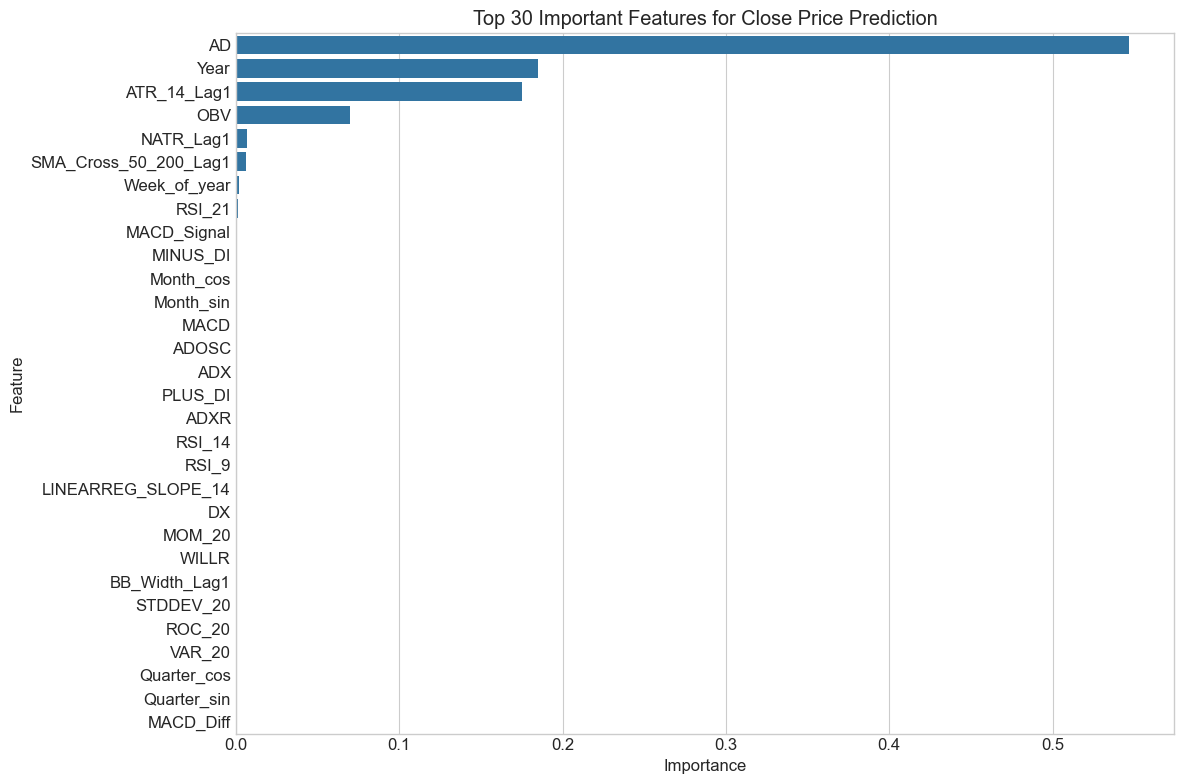


★ 重要度 X ドリフト検出 結果（上位）:
                  Feature  Importance  ks_stat  p_value  drift_detected
0                      AD    0.546923   0.9982   0.0000            True
1                    Year    0.184720   0.9885   0.0000            True
2             ATR_14_Lag1    0.175135   0.6798   0.0000            True
3                     OBV    0.069659   0.7663   0.0000            True
4               NATR_Lag1    0.006859   0.7149   0.0000            True
5   SMA_Cross_50_200_Lag1    0.005947   0.5123   0.0000            True
6            Week_of_year    0.002051   0.4427   0.0000            True
7                  RSI_21    0.001178   0.3645   0.0005            True
8             MACD_Signal    0.000969   0.5580   0.0000            True
9                MINUS_DI    0.000806   0.3003   0.0069            True
10              Month_cos    0.000584   0.8280   0.0000            True
11              Month_sin    0.000484   0.4117   0.0000            True
12                   MACD    0.000432   

In [7]:
"""
NTT株価データの特徴量エンジニアリング
技術力強化版 - 可読性向上とコード構造化
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import ks_2samp
import talib
import warnings

warnings.filterwarnings('ignore')

# グラフ設定
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12


class StockFeatureEngineer:
    """株価データの特徴量エンジニアリングクラス"""
    
    def __init__(self, data_path: str):
        """
        初期化
        
        Args:
            data_path (str): CSVファイルのパス
        """
        self.data_path = data_path
        self.df = None
        self.df_features = None
        
    def load_data(self) -> pd.DataFrame:
        """データの読み込み"""
        self.df = pd.read_csv(self.data_path)
        self.df['Date'] = pd.to_datetime(self.df['Date'])
        return self.df
    
    def _create_time_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """時間関連の特徴量を生成"""
        # 基本的な時間特徴量
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['Day'] = df['Date'].dt.day
        df['Weekday'] = df['Date'].dt.dayofweek
        df['Quarter'] = df['Date'].dt.quarter
        df['Week_of_year'] = df['Date'].dt.isocalendar().week
        df['Is_month_start'] = df['Date'].dt.is_month_start.astype(int)
        df['Is_month_end'] = df['Date'].dt.is_month_end.astype(int)
        
        # 周期性を考慮したsin/cos変換
        df['Weekday_sin'] = np.sin(2 * np.pi * df['Weekday'] / 7)
        df['Weekday_cos'] = np.cos(2 * np.pi * df['Weekday'] / 7)
        df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
        df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
        df['Quarter_sin'] = np.sin(2 * np.pi * df['Quarter'] / 4)
        df['Quarter_cos'] = np.cos(2 * np.pi * df['Quarter'] / 4)
        
        return df
    
    def _create_price_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """価格関連の基本特徴量を生成（未来リーク防止）"""
        # 基本リターン系（過去情報のみ使用）
        df['Daily_Return'] = df['Close'].pct_change()
        df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
        
        # ギャップ（前日終値と当日始値の差）
        df['Gap'] = (df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)
        
        # 同日価格情報は未来リークのため除外
        # Range, Body, Shadow系は使用しない
        
        return df
    
    def _create_technical_indicators(self, df: pd.DataFrame) -> pd.DataFrame:
        """TALibを使用したテクニカル指標を生成"""
        high = df['High'].astype(np.float64).values
        low = df['Low'].astype(np.float64).values
        close = df['Close'].astype(np.float64).values
        open_price = df['Open'].astype(np.float64).values
        volume = df['Volume'].astype(np.float64).values
        
        # 移動平均・EMA（ラグ版のみ使用で未来リーク防止）
        for period in [5, 10, 20, 50, 100, 200]:
            # 移動平均を一日シフトして未来リークを防ぐ
            df[f'SMA_{period}_Lag1'] = pd.Series(talib.SMA(close, timeperiod=period)).shift(1)
            if period <= 50:
                df[f'EMA_{period}_Lag1'] = pd.Series(talib.EMA(close, timeperiod=period)).shift(1)
        
        # RSI
        for period in [9, 14, 21]:
            df[f'RSI_{period}'] = talib.RSI(close, timeperiod=period)
        
        # MACD
        macd, macd_signal, macd_hist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
        df['MACD'] = macd
        df['MACD_Signal'] = macd_signal
        df['MACD_Hist'] = macd_hist
        
        # ストキャスティクス
        slowk, slowd = talib.STOCH(high, low, close, 14, 3, 3)
        df['STOCH_K'] = slowk
        df['STOCH_D'] = slowd
        
        # その他のオシレーター
        df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)
        df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
        
        # モメンタム系
        for period in [5, 10, 20]:
            df[f'ROC_{period}'] = talib.ROC(close, timeperiod=period)
            df[f'MOM_{period}'] = talib.MOM(close, timeperiod=period)
        
        # ボラティリティ系（ラグ版で未来リーク防止）
        df['ATR_14_Lag1'] = pd.Series(talib.ATR(high, low, close, timeperiod=14)).shift(1)
        df['NATR_Lag1'] = pd.Series(talib.NATR(high, low, close, timeperiod=14)).shift(1)
        
        # ボリンジャーバンド（ラグ版で未来リーク防止）
        bb_upper, bb_middle, bb_lower = talib.BBANDS(close, 20, 2, 2)
        df['BB_Upper_Lag1'] = pd.Series(bb_upper).shift(1)
        df['BB_Middle_Lag1'] = pd.Series(bb_middle).shift(1)
        df['BB_Lower_Lag1'] = pd.Series(bb_lower).shift(1)
        df['BB_Width_Lag1'] = ((pd.Series(bb_upper).shift(1) - pd.Series(bb_lower).shift(1)) / 
                               pd.Series(bb_middle).shift(1))
        
        # 出来高系
        df['AD'] = talib.AD(high, low, close, volume)
        df['ADOSC'] = talib.ADOSC(high, low, close, volume, 3, 10)
        df['OBV'] = talib.OBV(close, volume)
        df['OBV_Change'] = df['OBV'].pct_change()
        
        # ローソク足パターン
        df['CDLDOJI'] = talib.CDLDOJI(open_price, high, low, close)
        df['CDLHAMMER'] = talib.CDLHAMMER(open_price, high, low, close)
        df['CDLENGULFING'] = talib.CDLENGULFING(open_price, high, low, close)
        
        # 統計系
        for period in [5, 10, 20]:
            df[f'STDDEV_{period}'] = talib.STDDEV(close, timeperiod=period)
        
        df['VAR_20'] = talib.VAR(close, timeperiod=20)
        df['LINEARREG_14'] = talib.LINEARREG(close, timeperiod=14)
        df['LINEARREG_SLOPE_14'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
        df['TSF_14'] = talib.TSF(close, timeperiod=14)
        
        # 価格系
        df['TYPPRICE'] = talib.TYPPRICE(high, low, close)
        df['WCLPRICE'] = talib.WCLPRICE(high, low, close)
        df['MEDPRICE'] = talib.MEDPRICE(high, low)
        
        # アルーン系
        aroon_down, aroon_up = talib.AROON(high, low, timeperiod=14)
        df['AROON_DOWN'] = aroon_down
        df['AROON_UP'] = aroon_up
        df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
        
        # ADX系
        df['DX'] = talib.DX(high, low, close, timeperiod=14)
        df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
        df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
        df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
        df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
        
        return df
    
    def _create_lag_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """ラグ特徴量を生成"""
        close = df['Close'].astype(np.float64).values
        
        # 過去の値（Daily_Returnを使用）
        for lag in [1, 2, 3, 5, 10]:
            df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)
            df[f'Return_Lag_{lag}'] = df['Daily_Return'].shift(lag)
            df[f'Volume_Lag_{lag}'] = df['Volume'].shift(lag)
            
            # ラグ版テクニカル指標（さらにラグを加えて未来リーク防止）
            if lag <= 5:
                df[f'SMA_5_Lag_{lag+1}'] = pd.Series(talib.SMA(close, timeperiod=5)).shift(lag+1)
                df[f'EMA_5_Lag_{lag+1}'] = pd.Series(talib.EMA(close, timeperiod=5)).shift(lag+1)
            if lag <= 3:
                df[f'SMA_20_Lag_{lag+1}'] = pd.Series(talib.SMA(close, timeperiod=20)).shift(lag+1)
                df[f'RSI_14_Lag_{lag+1}'] = pd.Series(talib.RSI(close, timeperiod=14)).shift(lag+1)
        
        # 未来の値（予測用ラベルのみ、特徴量としては使用しない）
        for forward in [1, 3, 5, 10]:
            df[f'Forward_Return_{forward}d'] = df['Close'].pct_change(periods=forward).shift(-forward)
            df[f'Forward_Direction_{forward}d'] = np.where(df[f'Forward_Return_{forward}d'] > 0, 1, 0)
        
        return df
    
    def _create_extended_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """拡張特徴量を生成"""
        close = df['Close'].astype(np.float64).values
        volume = df['Volume'].astype(np.float64).values
        
        # 出来高関連
        df['Volume_Change'] = df['Volume'].pct_change()
        df['Volume_Ratio_5'] = df['Volume'] / df['Volume'].rolling(5).mean()
        
        # ゴールデンクロス・デッドクロス（ラグ版）
        sma_50_lag = pd.Series(talib.SMA(close, timeperiod=50)).shift(1)
        sma_200_lag = pd.Series(talib.SMA(close, timeperiod=200)).shift(1)
        df['SMA_Cross_50_200_Lag1'] = (sma_50_lag > sma_200_lag).astype(int)
        
        # MACD差分
        macd, macd_signal, _ = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
        df['MACD_Diff'] = macd - macd_signal
        
        # 加速度的特徴量（適切なラグで修正）
        return_5d_lag = df['Close'].pct_change(5).shift(6)  # 5日リターンをさらに1日シフト
        return_10d_lag = df['Close'].pct_change(10).shift(11)  # 10日リターンをさらに1日シフト
        df['Acceleration_5_10'] = return_5d_lag - return_10d_lag
        
        # イベントフラグ
        df['Is_Earnings_Season'] = df['Date'].dt.month.isin([3, 6, 9, 12]).astype(int)
        df['Is_Month_End'] = df['Date'].dt.is_month_end.astype(int)
        
        return df
    
    def generate_features(self) -> pd.DataFrame:
        """全ての特徴量を生成"""
        if self.df is None:
            raise ValueError("データが読み込まれていません。load_data()を先に実行してください。")
        
        df_feat = self.df.copy()
        
        # 各種特徴量を順次生成
        df_feat = self._create_time_features(df_feat)
        df_feat = self._create_price_features(df_feat)
        df_feat = self._create_technical_indicators(df_feat)
        df_feat = self._create_lag_features(df_feat)
        df_feat = self._create_extended_features(df_feat)
        
        # 欠損値を除去
        self.df_features = df_feat.dropna()
        
        return self.df_features
    
    def evaluate_feature_importance(self, target_col: str = 'Close', n_splits: int = 5) -> pd.DataFrame:
        """
        時系列対応の特徴量重要度評価（終値をターゲット）
        
        Args:
            target_col (str): 目的変数のカラム名（デフォルト: 'Close'）
            n_splits (int): 時系列分割数
            
        Returns:
            pd.DataFrame: 特徴量重要度のデータフレーム
        """
        if self.df_features is None:
            raise ValueError("特徴量が生成されていません。generate_features()を先に実行してください。")
        
        # 目的変数との相関でデータリーケージを自動検出
        target_series = self.df_features[target_col]
        high_corr_features = []
        
        for col in self.df_features.columns:
            if col != target_col and pd.api.types.is_numeric_dtype(self.df_features[col]):
                corr = abs(target_series.corr(self.df_features[col]))
                if corr > 0.95:  # 95%以上の相関でリーケージと判定
                    high_corr_features.append((col, corr))
        
        leakage_features = [col for col, _ in high_corr_features]
        
        print(f"\n高相関特徴量（リーケージの可能性）:")
        for col, corr in sorted(high_corr_features, key=lambda x: x[1], reverse=True):
            print(f"  {col}: {corr:.3f}")
        
        # 目的変数とターゲット列を除外する列を定義
        exclude_cols = [
            'Date', target_col,
            'Forward_Return_1d', 'Forward_Return_3d', 'Forward_Return_5d', 'Forward_Return_10d',
            'Forward_Direction_1d', 'Forward_Direction_3d', 'Forward_Direction_5d', 'Forward_Direction_10d'
        ] + leakage_features
        
        print(f"\n予測対象: {target_col}")
        print(f"除外された特徴量数: {len(leakage_features)}")
        print(f"使用される特徴量数: {len([col for col in self.df_features.columns if col not in exclude_cols])}")
        
        # 存在する列のみを除外
        exclude_cols = [col for col in exclude_cols if col in self.df_features.columns]
        
        # 相関チェック後の特徴量数を表示
        remaining_features = [col for col in self.df_features.columns if col not in exclude_cols]
        print(f"最終的に使用される特徴量数: {len(remaining_features)}")
        if len(remaining_features) < 10:
            print(f"使用特徴量: {remaining_features}")
        
        y = self.df_features[target_col].values
        X = self.df_features.drop(exclude_cols, axis=1)
        
        # カテゴリカル変数をダミー変数に変換
        categorical_cols = ['Weekday', 'Month', 'Quarter']
        existing_categorical_cols = [col for col in categorical_cols if col in X.columns]
        
        if existing_categorical_cols:
            X = pd.get_dummies(X, columns=existing_categorical_cols, drop_first=True)
        
        # 数値型のみを選択
        X = X.select_dtypes(include=[np.number])
        X_values = X.values
        feature_names = X.columns
        
        # 時系列分割で特徴量重要度を評価
        tscv = TimeSeriesSplit(n_splits=n_splits)
        importances = []
        
        for train_index, test_index in tscv.split(X_values):
            X_train, X_test = X_values[train_index], X_values[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            model = RandomForestRegressor(n_estimators=20, random_state=42)
            model.fit(X_train, y_train)
            importances.append(model.feature_importances_)
        
        # 平均重要度を計算
        mean_importance = np.mean(importances, axis=0)
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': mean_importance
        }).sort_values('Importance', ascending=False)
        
        return feature_importance
    
    def plot_feature_importance(self, feature_importance: pd.DataFrame, top_n: int = 30):
        """特徴量重要度をプロット"""
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(top_n))
        plt.title(f'Top {top_n} Important Features for Close Price Prediction')
        plt.tight_layout()
        plt.show()
    
    def run_drift_analysis(self, feature_importance: pd.DataFrame, test_size: int = 30) -> pd.DataFrame:
        """
        データドリフト分析を実行
        
        Args:
            feature_importance (pd.DataFrame): 特徴量重要度
            test_size (int): テストデータのサイズ
            
        Returns:
            pd.DataFrame: ドリフト分析結果
        """
        if self.df_features is None:
            raise ValueError("特徴量が生成されていません。")
        
        # データ分割
        df_future = self.df_features.tail(test_size)
        df_train = self.df_features.iloc[:-test_size]
        
        # KS検定実行
        ks_results = []
        common_cols = set(df_train.columns).intersection(set(df_future.columns))
        
        for col in common_cols:
            if pd.api.types.is_numeric_dtype(df_train[col]):
                stat, p = ks_2samp(df_train[col].dropna(), df_future[col].dropna())
                ks_results.append({
                    'Feature': col,
                    'ks_stat': round(stat, 4),
                    'p_value': round(p, 4),
                    'drift_detected': p < 0.05
                })
        
        ks_result = pd.DataFrame(ks_results).sort_values('ks_stat', ascending=False)
        
        # 重要度とマージ
        combined_result = pd.merge(feature_importance, ks_result, on='Feature', how='inner')
        combined_result = combined_result.sort_values(['drift_detected', 'Importance'], ascending=[False, False])
        
        return combined_result
    
    def save_results(self, output_dir: str):
        """結果を保存"""
        if self.df_features is None:
            raise ValueError("特徴量が生成されていません。")
        
        # 特徴量データを保存
        features_path = f"{output_dir}\\features_talib.csv"
        self.df_features.to_csv(features_path, index=False)
        print(f"特徴量データを保存しました: {features_path}")
        
        return features_path


def main():
    """メイン処理"""
    # データパス
    data_path = r"C:\Users\Take\python\ntt-stock-prediction_test\data\data.csv"
    output_dir = r"C:\Users\Take\python\ntt-stock-prediction_test\data"
    
    # 特徴量エンジニアリング実行
    engineer = StockFeatureEngineer(data_path)
    
    # データ読み込み
    df = engineer.load_data()
    print(f"データ読み込み完了: {df.shape}")
    
    # 特徴量生成
    df_features = engineer.generate_features()
    print(f"生成された特徴量の数: {df_features.shape[1] - 1}")
    print(f"データ行数: {df_features.shape[0]}")
    
    # TALib特徴量の確認
    talib_features = [col for col in df_features.columns if any(x in col for x in 
                     ['RSI', 'MACD', 'STOCH', 'WILLR', 'CCI', 'ROC', 'MOM', 'ATR', 'NATR', 
                      'BB_', 'AD', 'OBV', 'CDL', 'STDDEV', 'VAR', 'LINEARREG', 'TSF',
                      'TYPPRICE', 'WCLPRICE', 'MEDPRICE', 'AROON', 'DX', 'ADX', 'PLUS_DI', 'MINUS_DI'])]
    
    print(f"\nTALibで生成された特徴量数: {len(talib_features)}")
    
    # 特徴量重要度評価（終値をターゲット）
    feature_importance = engineer.evaluate_feature_importance(target_col='Close')
    print("\n上位の特徴量（Top 30）:")
    print(feature_importance.head(30))
    
    # 重要度プロット
    engineer.plot_feature_importance(feature_importance)
    
    # ドリフト分析
    combined_result = engineer.run_drift_analysis(feature_importance)
    print("\n★ 重要度 X ドリフト検出 結果（上位）:")
    print(combined_result.head(30))
    
    # 結果保存
    engineer.save_results(output_dir)
    
    # 上位特徴量保存
    top_30 = feature_importance.head(35)
    top_30_path = f"{output_dir}\\top_30_feature_importance.csv"
    top_30.to_csv(top_30_path, index=False)
    print(f"上位30特徴量を保存しました: {top_30_path}")
    
    # ドリフト分析結果保存
    drift_path = f"{output_dir}\\feature_drift_analysis.csv"
    combined_result.to_csv(drift_path, index=False)
    print(f"分析結果を保存しました: {drift_path}")
    
    return df_features, feature_importance, combined_result


if __name__ == "__main__":
    df_features, feature_importance, combined_result = main()